In [1]:
import pandas as pd;
import numpy as np;
# import pyplot as plt;
import matplotlib as mplot;
%matplotlib inline

In [2]:
raw = pd.read_csv('data/2017-Q1-Trips-History-Data.csv')

In [45]:
raw.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type,Duration (s),Duration (m)
0,1048876,3/31/2017 23:59,4/1/2017 0:17,31213,17th & K St NW,31606,Potomac & Pennsylvania Ave SE,W20784,Registered,1048.876,17.481267
1,223449,3/31/2017 23:59,4/1/2017 0:03,31104,Adams Mill & Columbia Rd NW,31103,16th & Harvard St NW,W20825,Registered,223.449,3.724150
2,423494,3/31/2017 23:58,4/1/2017 0:05,31627,M St & Delaware Ave NE,31614,11th & H St NE,W20773,Registered,423.494,7.058233
3,687015,3/31/2017 23:57,4/1/2017 0:08,31404,9th & Upshur St NW,31281,8th & O St NW,W01307,Registered,687.015,11.450250
4,257919,3/31/2017 23:57,4/1/2017 0:02,31602,Park Rd & Holmead Pl NW,31400,Georgia & New Hampshire Ave NW,W21760,Registered,257.919,4.298650


Looks like we are provided with:
- trip duration
- start/end dates
- start location
- end location
- bike ID
- membership type

Initial questions we can answer include:
- Do registered members take longer/shorter trips than casual users?
    - What days of the week experience greater use from particular Member Types?
        - e.g. 'commuter behavior'
- Are certain bikes experiencing disproportionately high use?
    - is this a consequence of being located at busier stations?
- Does CaBi relocate bikes to evenly distribute wear-and-tear?
    - e.g. does a particular bike begin a trip at a station different from the end destination of it's last trip?
        - CaBi cleansed staff rides from the dataset, but we can deduce when this occurs
- How often do users return a bike to the start location?
    - are certain locations more conducive to this 'boomerang' behavior?

In [4]:
grouped_by_membership = raw.groupby('Member Type')

In [30]:
# CaBi Data Documentation (https://www.capitalbikeshare.com/system-data)
# This data has been processed to remove trips that are taken by staff as they service and inspect the system, 
# trips that are taken to/from any of our “test” stations at our warehouses and any trips lasting less than 60 seconds
shortest_trip_in_ms = (raw['Duration'].min() / (1000))
print("Assuming Duration is ms, shortest trip is {0} seconds".format(shortest_trip_in_ms))
print()
print("{0} > 60, so our assumption is".format(shortest_trip_in_ms), shortest_trip_in_ms>60)

Assuming Duration is ms, shortest trip is 60.004 seconds

60.004 > 60, so our assumption is True


In [32]:
# Sanity check: this ride indeed lasted 1 minute
raw[raw['Duration']==raw['Duration'].min()]

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type
241987,60004,3/1/2017 12:10,3/1/2017 12:11,31007,Crystal City Metro / 18th & Bell St,31007,Crystal City Metro / 18th & Bell St,W21302,Registered


In [35]:
raw['Duration (s)'] = raw['Duration']/1000
raw['Duration (m)'] = raw['Duration (s)']/60

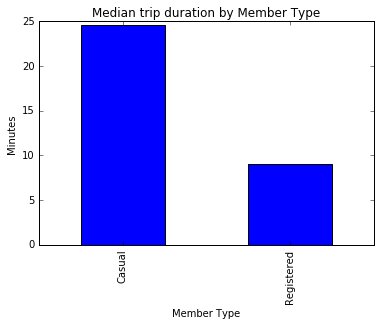

In [43]:
grouped_by_membership['Duration (m)'].median().plot(kind='bar', title="Median trip duration by Member Type").set_ylabel('Minutes')

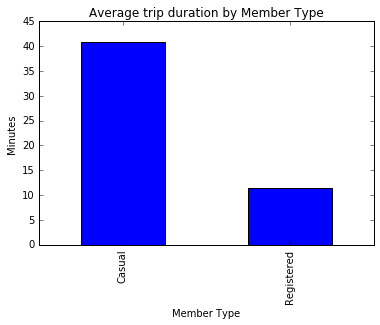

In [44]:
grouped_by_membership['Duration (m)'].mean().plot(kind='bar', title="Average trip duration by Member Type").set_ylabel('Minutes')

In [ ]:
# Casual riders appear to use the bikes for longer than registered users. 
# This is likely due to Casual members taking leisurely rides, while Registered members tend to be commuters
#  - commuting to metro stations?

